In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils as u

# %matplotlib widget

In [3]:
# Load audiofile at 16kHz
audiofile = "thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin_edited.mp3"
sr = 16000
y, sr = u.load_normalize(audiofile, sr = sr)

# Apply a high pass filter to the audio signal (160 Hz)
y_filt = u.high_pass(y, sr, 160, order = 10)
y_filt = y_filt.astype(np.float32)  

In [4]:
# Identify the tonic
tonic = u.identify_tonic(y, sr, binResolution = 1)
print(f"Identified tonic: {tonic} Hz")

Identified tonic: 181.02346801757812 Hz


In [5]:
# Calculate raw pitch with melodia
hopsize_ms = 7.5
binResolution = 1
hopSize = u.ms_to_samples(hopsize_ms, sr)
minFrequency = tonic - 1
f0, conf = u.melodia(y, sr, hopSize = hopSize, minFrequency = minFrequency, binResolution = binResolution)

In [6]:
# Length of audio in seconds
length = len(y)/sr
# Pitch contour frame rate
frameRate = int(len(f0)/length)  

print("Pitch contour frame rate: ", frameRate)

Pitch contour frame rate:  133


In [7]:
# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print(len(voiced_segments))

826


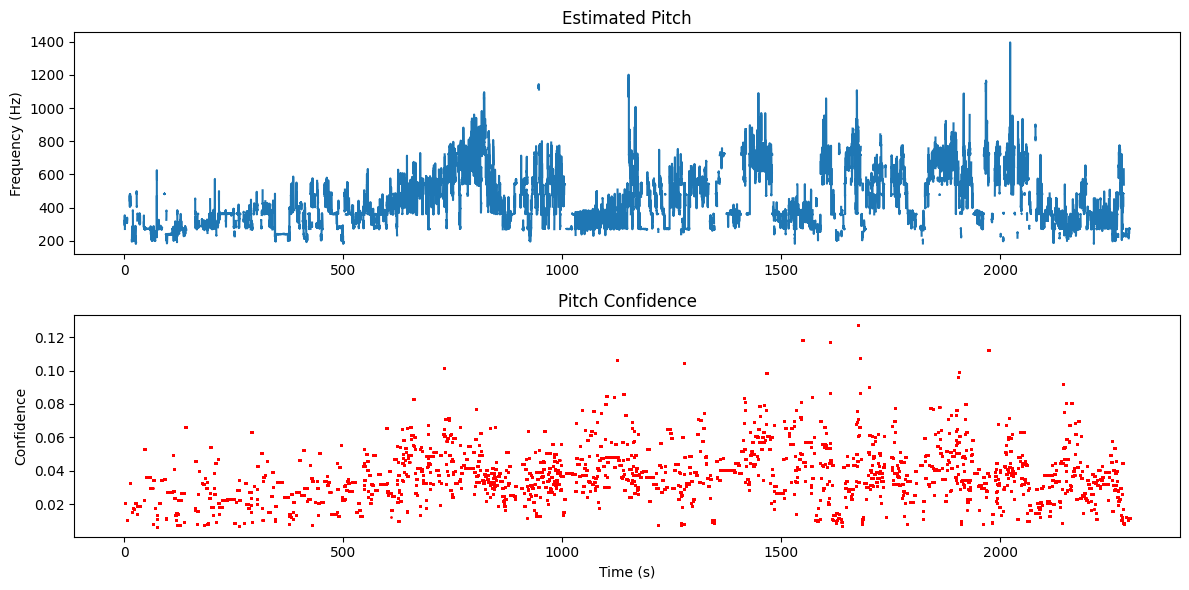

In [9]:
u.plot_pitch(f0, conf, y, sr)

In [10]:
# Sonify pitch contour and save
times = np.linspace(0, len(y)/sr, len(f0))
y_pitch = u.sonify_pitch_contour(times, f0, sr = sr)
u.save_audio("thodi/Koluvamaregatha/Koluvamaregatha.multitrack-violin_pitch.wav", y_pitch, sr)

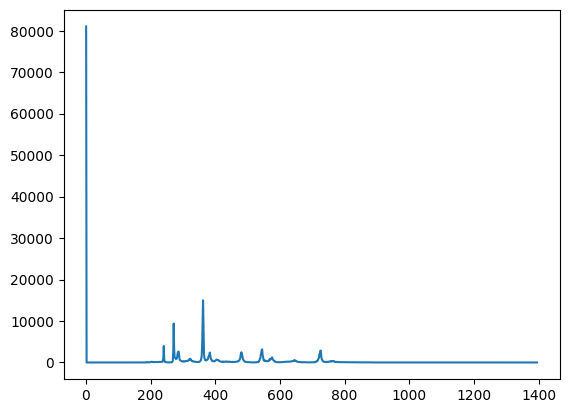

[271.4131  362.11667]


In [29]:
hist, bin_edges = np.histogram(f0, bins = 1000)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
plt.plot(bin_centers, hist)
plt.show()
peaks, _ = u.find_peaks(hist, height = 5000)
print(bin_centers[peaks])

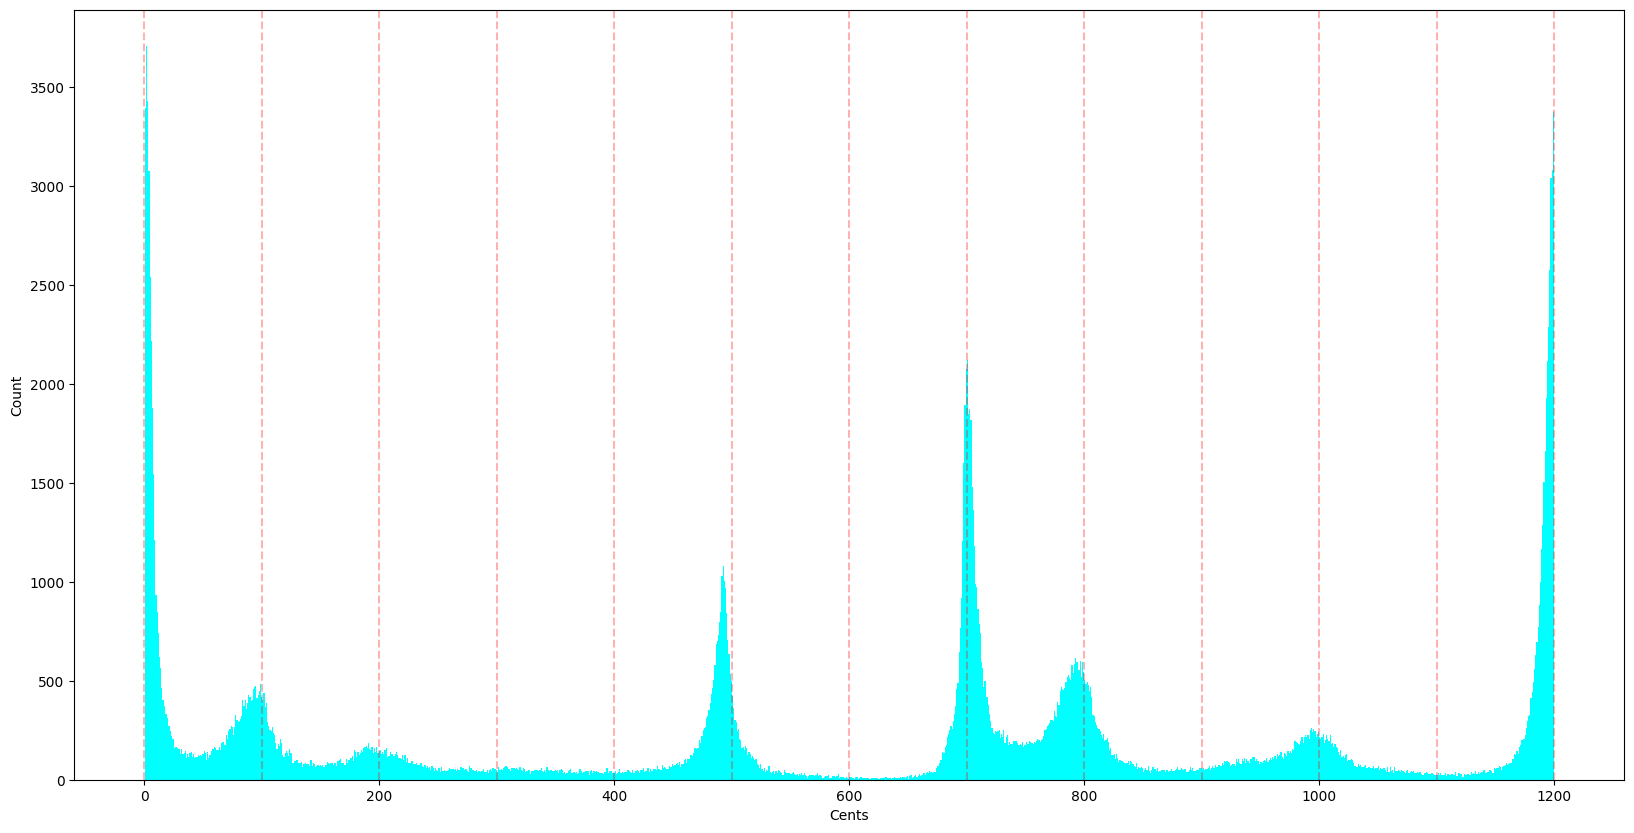

In [32]:
# Convert to cents and plot
cents = u.hz_to_cents(f0, tonic)
# Wrap cents to one octave
cents = u.wrap_to_octave(cents)
u.interval_histogram(cents, bins = 1200, tuning = "EQ")

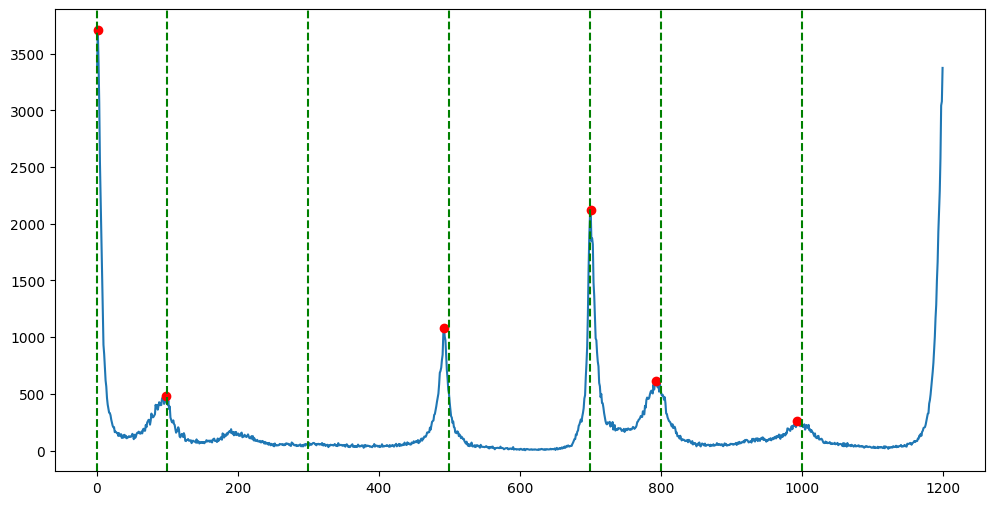

In [63]:
exp_positions = np.array([0, 100, 300, 500, 700, 800, 1000])
bins = np.linspace(0, 1200, 1201)
hist, bin_edges = np.histogram(cents, bins = bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2    
peaks, _ = u.find_peaks(hist, height = 100, distance = 50)
# Filter peaks such that only peaks near expected positions are retained
peaks = [peak for peak in peaks if np.any(np.abs(exp_positions - bin_centers[peak]) < 50)]
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist)
plt.plot(bin_centers[peaks], hist[peaks], 'ro')
for pos in exp_positions:
    plt.axvline(x = pos, color = 'g', linestyle = '--')
plt.show()

In [65]:
# Now that peak positions are known, take the histogram curve -50 and +50 around each peak and fit a gaussian
peak_dict = {}

for peak in peaks:
    # Calculate start and end indices, considering wrap-around
    start = peak - 50
    end = peak + 50
    
    # Handle wrap-around for start index
    if start < 0:
        x_left = bin_centers[start:]  # From start index to the end
        x_right = bin_centers[:end]  # Starting from the beginning
        x = np.concatenate((x_left, x_right))  # Combine both parts
        y_left = hist[start:]
        y_right = hist[:end]
        y = np.concatenate((y_left, y_right))
    elif end > len(bin_centers):
        # Handle wrap-around for end index
        overflow = end - len(bin_centers)
        x_left = bin_centers[start:]  # From start index to the end
        x_right = bin_centers[:overflow]  # Starting from the beginning
        x = np.concatenate((x_left, x_right))  # Combine both parts
        y_left = hist[start:]
        y_right = hist[:overflow]
        y = np.concatenate((y_left, y_right))
    else:
        # No wrap-around needed
        x = bin_centers[start:end]
        y = hist[start:end]
    
    # Fit a gaussian here
    popt, pcov = u.curve_fit(u.gaussian, x, y)
    peak_dict[bin_centers[peak]] = popt

/tmp/ipykernel_603/3291966984.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = u.curve_fit(u.gaussian, x, y)


In [66]:
print(peak_dict)

{1.5: array([ 15118.1788875 , 133009.23854783,  53102.84538403]), 98.5: array([1., 1., 1.]), 492.5: array([1., 1., 1.]), 700.5: array([1., 1., 1.]), 792.5: array([1., 1., 1.]), 993.5: array([1., 1., 1.])}


In [47]:
# Load the pitch file for the vocals, and tonic file
pitch_file = "thodi/Koluvamaregatha/Koluvamaregatha.pitch.txt"
tonic_file = "thodi/Koluvamaregatha/Koluvamaregatha.ctonic.txt"
# Parse the pitch file, first column is time, second column is pitch
times, f0_vocals, _ = u.parse_pitch_file(pitch_file)
tonic_vocals = np.loadtxt(tonic_file)

In [48]:
print(len(f0_vocals[f0_vocals!=0]))
print(len(f0[f0!=0]))

483423
225867


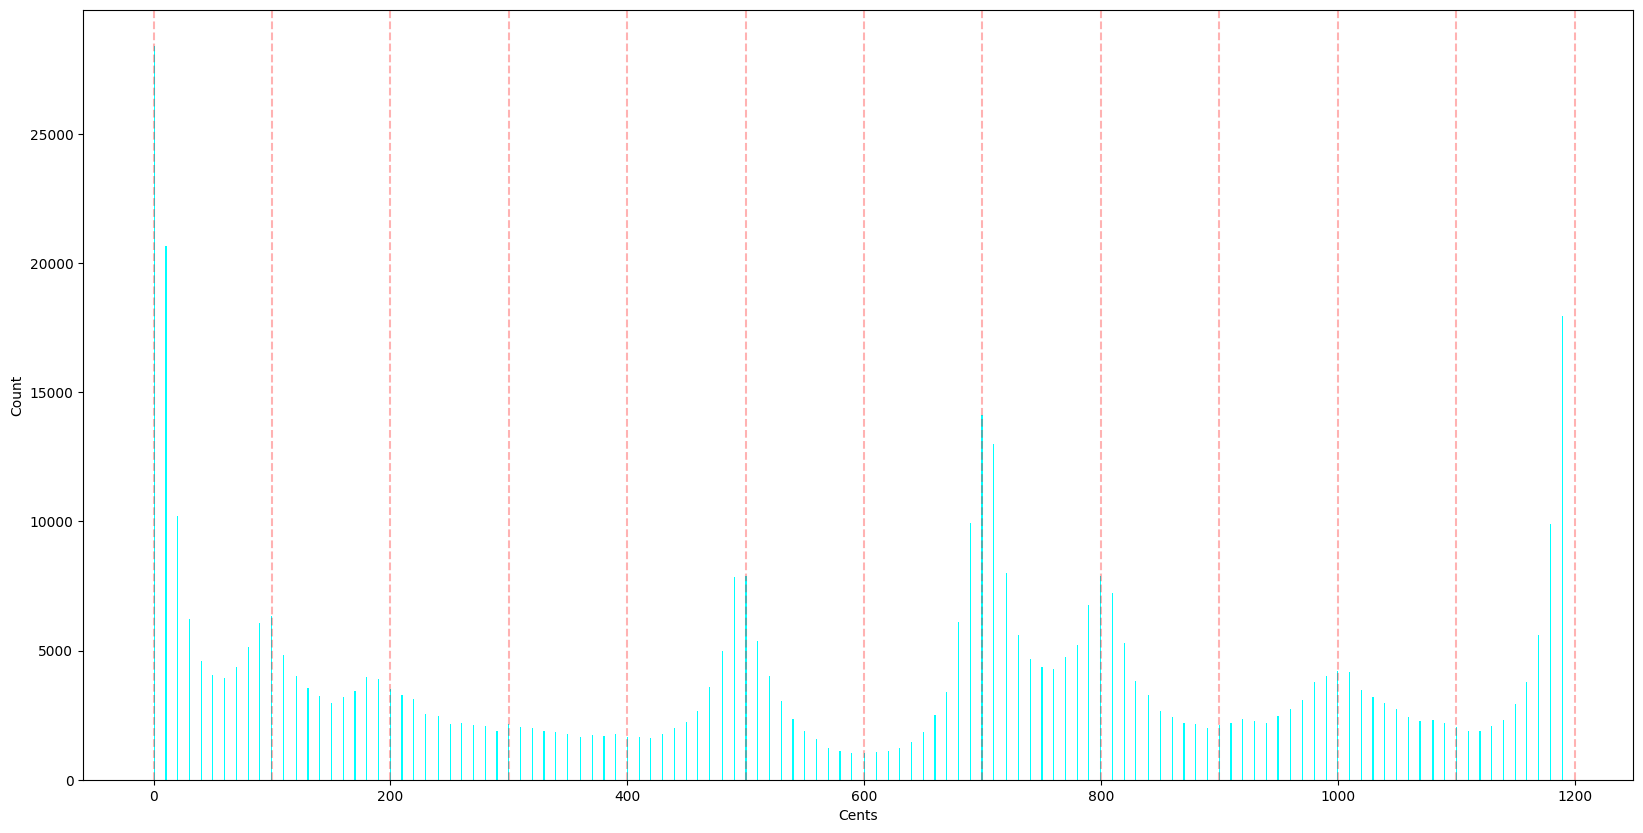

In [54]:
# Convert to cents and plot
cents = u.hz_to_cents(f0_vocals, tonic_vocals)
# Wrap cents to one octave
cents = u.wrap_to_octave(cents)
u.interval_histogram(cents, bins = 1200, tuning = "EQ")